# ライブラリ

In [1]:
from typing import Tuple
import fractions
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit.circuit.library import MCXGate
from qiskit.extensions import UnitaryGate
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# 目次
1. [Deutsch-Jozsa アルゴリズム](#deutsch-jozsa-アルゴリズム)
2. [Grover アルゴリズム](#grover-アルゴリズム)
3. [Shor アルゴリズム](#shor-アルゴリズム)
4. [素因数分解問題](#素因数分解問題)

# Deutsch-Jozsa アルゴリズム

### オラクル $f$ の実装

In [2]:
def oracle_dj(n: int, balanced: bool) -> Gate:
    qr = QuantumRegister(n+1)
    qc = QuantumCircuit(qr)
    if balanced:
        ones_list = np.random.choice(range(2**n), 2**(n-1), replace=False)
        for ind in ones_list:
            ind_bin = np.binary_repr(ind).zfill(n)
            qc.append(MCXGate(n, ctrl_state=ind_bin), qr)
    return qc.to_gate(label="Oracle")

### Deutsch-Jozsa アルゴリズムの実装

In [3]:
def deutsch_jozsa(n: int, balanced: bool) -> QuantumCircuit:
    qr = QuantumRegister(n+1, name="qubit")
    cr = ClassicalRegister(n, name="measure")
    qc = QuantumCircuit(qr, cr)

    # Step 1
    qc.x(qr[n])

    # Step 2
    qc.h(qr)

    # Step 3
    qc.append(oracle_dj(n, balanced), qr)

    # Step4
    qc.h(qr[:n])

    # Step5
    qc.measure(qr[:n], cr[::-1])  # 表示した時左から順に qr[0], qr[1], ...

    return qc

### 回路図

In [4]:
qc_const = deutsch_jozsa(4, False)
qc_balanced = deutsch_jozsa(4, True)
qc_balanced.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
  qubit_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
           ├───┤     │         │├───┤└╥┘┌─┐      
  qubit_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
           ├───┤     │         │├───┤ ║ └╥┘┌─┐   
  qubit_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
           ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
  qubit_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
           ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
  qubit_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
           └───┘└───┘└─────────┘      ║  ║  ║  ║ 
measure: 4/═══════════════════════════╩══╩══╩══╩═
                                      3  2  1  0

### 実行

定数関数の場合、 $\left|0000\right>$ のみが観測される。

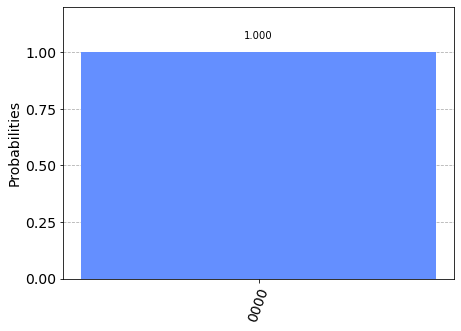

In [5]:
backend_const = QasmSimulator()
qc_const_compiled = transpile(qc_const, backend_const)
job_sim_const = backend_const.run(qc_const_compiled, shots=1024)
result_sim_const = job_sim_const.result()
counts_const = result_sim_const.get_counts(qc_const_compiled)
plot_histogram(counts_const)

バランス関数の場合、オラクル $f$ によって確率分布は変わってしまうが、 $\left|0000\right>$ が観測されることはない。

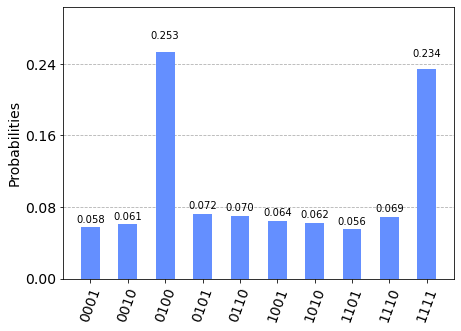

In [6]:
backend_balanced = QasmSimulator()
qc_balanced_compiled = transpile(qc_balanced, backend_balanced)
job_sim_balanced = backend_balanced.run(qc_balanced_compiled, shots=1024)
result_sim_balanced = job_sim_balanced.result()
counts_balanced = result_sim_balanced.get_counts(qc_balanced_compiled)
plot_histogram(counts_balanced)

# Grover アルゴリズム

### オラクル $f$ の実装

In [7]:
def oracle_g(n: int) -> Gate:
    qr = QuantumRegister(n+1)
    qc = QuantumCircuit(qr)
    ind = np.random.randint(0, 2**n)
    ind_bin = np.binary_repr(ind).zfill(n)
    qc.append(MCXGate(n, ctrl_state=ind_bin), qr)
    return qc.to_gate(label=f"Oracle \"{ind_bin[::-1]}\"")

### Grover 拡散行列 $D_N$ の実装

In [8]:
def diffusion_matrix(n: int) -> Gate:
    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr)
    mat = np.ones((2**n, 2**n)) * 2 / (2**n)
    mat[range(2**n), range(2**n)] -= 1
    qc.append(UnitaryGate(mat), qr)
    return qc.to_gate(label="Diffusion Matrix")

### Grover アルゴリズムの実装

In [9]:
def grover(n: int) -> QuantumCircuit:
    qr = QuantumRegister(n+1, name="qubit")
    cr = ClassicalRegister(n, name="measure")
    qc = QuantumCircuit(qr, cr)
    oracle_gate = oracle_g(n)

    # Step 0
    qc.x(qr[n])

    # Step 1
    qc.h(qr)

    # Step 2
    theta = np.arcsin(np.sqrt(1 / 2**n))

    for _ in range(int(np.floor(np.pi / (4 * theta)))):
        qc.append(oracle_gate, qr)  # Step 3
        qc.append(diffusion_matrix(n), qr[:n])  # Step 4
    
    # Step 5
    qc.measure(qr[:n], cr[::-1])  # 表示した時左から順に qr[0], qr[1], ...
    return qc

### 回路図

In [10]:
qc_grover = grover(4)
qc_grover.draw()

┌───┐     ┌────────────────┐┌───────────────────┐┌────────────────┐»
  qubit_0: ┤ H ├─────┤0               ├┤0                  ├┤0               ├»
           ├───┤     │                ││                   ││                │»
  qubit_1: ┤ H ├─────┤1               ├┤1                  ├┤1               ├»
           ├───┤     │                ││  Diffusion Matrix ││                │»
  qubit_2: ┤ H ├─────┤2 Oracle "1110" ├┤2                  ├┤2 Oracle "1110" ├»
           ├───┤     │                ││                   ││                │»
  qubit_3: ┤ H ├─────┤3               ├┤3                  ├┤3               ├»
           ├───┤┌───┐│                │└───────────────────┘│                │»
  qubit_4: ┤ X ├┤ H ├┤4               ├─────────────────────┤4               ├»
           └───┘└───┘└────────────────┘                     └────────────────┘»
measure: 4/═══════════════════════════════════════════════════════════════════»
                                                                              »
«           ┌───────────────────┐┌────────────────┐┌───────────────────┐┌─┐   »
«  qubit_0: ┤0                  ├┤0               ├┤0                  ├┤M├───»
«           │                   ││                ││                   │└╥┘┌─┐»
«  qubit_1: ┤1                  ├┤1               ├┤1                  ├─╫─┤M├»
«           │  Diffusion Matrix ││                ││  Diffusion Matrix │ ║ └╥┘»
«  qubit_2: ┤2                  ├┤2 Oracle "1110" ├┤2                  ├─╫──╫─»
«           │                   ││                ││                   │ ║  ║ »
«  qubit_3: ┤3                  ├┤3               ├┤3                  ├─╫──╫─»
«           └───────────────────┘│                │└───────────────────┘ ║  ║ »
«  qubit_4: ─────────────────────┤4               ├──────────────────────╫──╫─»
«                                └────────────────┘                      ║  ║ »
«measure: 4/═════════════════════════════════════════════════════════════╩══╩═»
«                                                                        3  2 »
«                 
«  qubit_0: ──────
«                 
«  qubit_1: ──────
«           ┌─┐   
«  qubit_2: ┤M├───
«           └╥┘┌─┐
«  qubit_3: ─╫─┤M├
«            ║ └╥┘
«  qubit_4: ─╫──╫─
«            ║  ║ 
«measure: 4/═╩══╩═
«            1  0

### 実行
上記の回路図の `Oracle` の横に、正解となるビット列を記載してある。

実行結果を見ると、正解ラベルのところだけ観測される確率が非常に高くなっている様子が見て取れる。

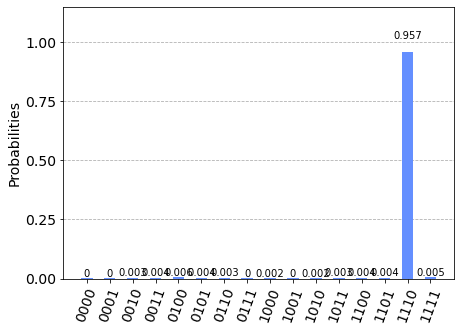

In [11]:
backend_grover = QasmSimulator()
qc_grover_compiled = transpile(qc_grover, backend_grover)
job_sim_grover = backend_grover.run(qc_grover_compiled, shots=1024)
result_sim_grover = job_sim_grover.result()
counts_grover = result_sim_grover.get_counts(qc_grover_compiled)
plot_histogram(counts_grover)

# Shor アルゴリズム

### 汎用関数の実装

In [12]:
def calc_order(a: int, N: int) -> int:
    tmp = 1
    for i in range(1, N):
        tmp *= a
        tmp %= N
        if tmp == 1:
            return i


def ceil_log2(N: int) -> int:
    retval = 0
    tmp = 1
    while tmp < N:
        tmp *= 2
        retval += 1
    return retval


def parse_result(result: dict) -> dict:
    retval = {}
    for key, val in result.items():
        _, key2 = key.split()
        if key2 in retval:
            retval[key2] += val
        else:
            retval[key2] = val
    return retval


def guess_period(result: dict, N):
    guessed = {}
    count = 0
    for key, val in result.items():
        if count == 0:
            pow2 = 2 ** len(key)
        phase = int(key, 2) / pow2
        frac = fractions.Fraction(phase).limit_denominator(N)
        if frac.denominator in guessed:
            guessed[frac.denominator] += val
        else:
            guessed[frac.denominator] = val
    retval = -1
    tmpmax = 0
    for r, p in guessed.items():
        if tmpmax < p:
            retval = r
            tmpmax = p
    return retval

### 周期を発見したい関数の実装
具体的には、 $f(x) = a^x \mod N$ で、 $f(r) = 1$ となる最小の整数 $r$ を求める。

$a$ を掛ける処理のユニタリーゲートに対応する $U$ の実装について、 $U_{f}$ のサイズは、使用するqubit数を $n$ とした時に $2^{n} \times 2^{n}$ となるが、
$\left\{\begin{array}{cl}
U_{(a \times i \mod N), i} = 1 & (i < N)\\
U_{i, i} = 1 & (i \geqq N)
\end{array}\right.$ 
とすれば実現できる。これがユニタリー行列となることは容易に示せる。

Qiskit では、0ビット目が0, 1ビット目が0, 2ビット目が1 の時、 $\left|001\right> = \left|1\right>\otimes\left|0\right>\otimes\left|0\right>$ と表すことに注意。

In [13]:
def time_a_matrix(a: int, N: int) -> np.ndarray:
    n = ceil_log2(N)
    retmat = np.zeros((2**n, 2**n))
    for i in range(2**n):
        if i >= N:
            ind_bin = np.binary_repr(i).zfill(n)
        else:
            ind_bin = np.binary_repr(a*i%N).zfill(n)
        retmat[int(ind_bin, 2), i] = 1
    return retmat


def periodic_function(a: int, N: int, additional: int) -> QuantumCircuit:
    n = ceil_log2(N)
    qr1 = QuantumRegister(n+additional)
    qr2 = QuantumRegister(n)
    qc = QuantumCircuit(qr1, qr2)

    unitary_matrix = time_a_matrix(a, N)  # times a (mod N)
    for i in range(n+additional):
        tmp_gate = UnitaryGate(unitary_matrix).control(1)
        qc.append(tmp_gate, qr1[[i]]+qr2[:])
        unitary_matrix = np.dot(unitary_matrix, unitary_matrix)
    return qc.to_gate(label="f")

### 量子フーリエ変換 (QFT) の実装
こちらも参照 $\rightarrow$ [Qiskit](https://qiskit.org/textbook/ja/ch-algorithms/shor.html)

In [14]:
def qft_dagger(n: int) -> Gate:
    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr)
    for i in range(n//2):
        qc.swap(qr[i], qr[n-1-i])
    for i in range(n):
        for j in range(i):
            qc.cp(-np.pi/float(2**(i-j)), qr[j], qr[i])
        qc.h(qr[i])
    return qc.to_gate(label="QFT†")

### Shor アルゴリズムの実装

In [15]:
def shor(a: int, N: int, additional: int = 0) -> QuantumCircuit:
    assert(np.gcd(a, N) == 1)
    n = ceil_log2(N)
    qr1 = QuantumRegister(n+additional, name="qubit-1")
    qr2 = QuantumRegister(n, name="qubit-2")
    cr1 = ClassicalRegister(n+additional, name="measure-1")
    cr2 = ClassicalRegister(n, name="measure-2")
    qc = QuantumCircuit(qr1, qr2, cr1, cr2)

    # Step 1
    qc.h(qr1)
    qc.x(qr2[0])

    # Step 2
    qc.append(periodic_function(a, N, additional), qr1[:]+qr2[:])

    # Step 3
    qc.measure(qr2, cr2)

    # Step 4
    qc.append(qft_dagger(n+additional), qr1)
    qc.measure(qr1, cr1)

    return qc

### 回路図
$additional$ な qubit を増やすことによって、計算量は多くなってしまうが、より細かな位相の差異まで分けることができるので、より精度のよい周期予測が可能となる。
特に、周期が 2 の階乗とならない場合に恩恵を受けることとなる。（講義資料で言うところの最後の補足のページ）以下のコードの $additional$ の値を 0 として実行してみると、違う結果が得られるだろう。

In [16]:
a, N, additional = 9, 14, 3
qc_shor = shor(a, N, additional)
qc_shor.draw()

┌───┐┌─────┐┌───────┐         ┌─┐                  
  qubit-1_0: ┤ H ├┤0    ├┤0      ├─────────┤M├──────────────────
             ├───┤│     ││       │         └╥┘┌─┐               
  qubit-1_1: ┤ H ├┤1    ├┤1      ├──────────╫─┤M├───────────────
             ├───┤│     ││       │          ║ └╥┘┌─┐            
  qubit-1_2: ┤ H ├┤2    ├┤2      ├──────────╫──╫─┤M├────────────
             ├───┤│     ││       │          ║  ║ └╥┘┌─┐         
  qubit-1_3: ┤ H ├┤3    ├┤3 QFT† ├──────────╫──╫──╫─┤M├─────────
             ├───┤│     ││       │          ║  ║  ║ └╥┘┌─┐      
  qubit-1_4: ┤ H ├┤4    ├┤4      ├──────────╫──╫──╫──╫─┤M├──────
             ├───┤│     ││       │          ║  ║  ║  ║ └╥┘┌─┐   
  qubit-1_5: ┤ H ├┤5  f ├┤5      ├──────────╫──╫──╫──╫──╫─┤M├───
             ├───┤│     ││       │          ║  ║  ║  ║  ║ └╥┘┌─┐
  qubit-1_6: ┤ H ├┤6    ├┤6      ├──────────╫──╫──╫──╫──╫──╫─┤M├
             ├───┤│     │└──┬─┬──┘          ║  ║  ║  ║  ║  ║ └╥┘
  qubit-2_0: ┤ X ├┤7    ├───┤M├─────────────╫──╫──╫──╫──╫──╫──╫─
             └───┘│     │   └╥┘   ┌─┐       ║  ║  ║  ║  ║  ║  ║ 
  qubit-2_1: ─────┤8    ├────╫────┤M├───────╫──╫──╫──╫──╫──╫──╫─
                  │     │    ║    └╥┘┌─┐    ║  ║  ║  ║  ║  ║  ║ 
  qubit-2_2: ─────┤9    ├────╫─────╫─┤M├────╫──╫──╫──╫──╫──╫──╫─
                  │     │    ║     ║ └╥┘┌─┐ ║  ║  ║  ║  ║  ║  ║ 
  qubit-2_3: ─────┤10   ├────╫─────╫──╫─┤M├─╫──╫──╫──╫──╫──╫──╫─
                  └─────┘    ║     ║  ║ └╥┘ ║  ║  ║  ║  ║  ║  ║ 
measure-1: 7/════════════════╬═════╬══╬══╬══╩══╩══╩══╩══╩══╩══╩═
                             ║     ║  ║  ║  0  1  2  3  4  5  6 
                             ║     ║  ║  ║                      
measure-2: 4/════════════════╩═════╩══╩══╩══════════════════════
                             0     1  2  3

### 実行

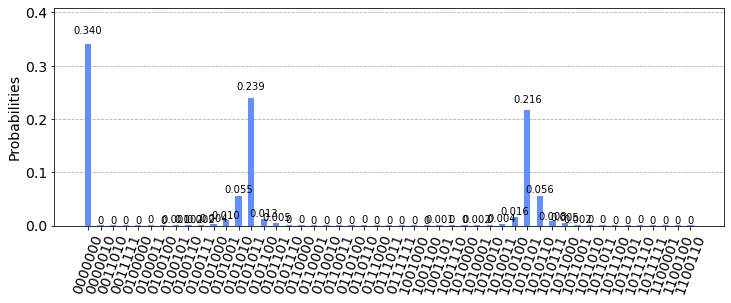

In [17]:
backend_shor = QasmSimulator()
qc_shor_compiled = transpile(qc_shor, backend_shor)
job_sim_shor = backend_shor.run(qc_shor_compiled, shots=2048)
result_sim_shor = job_sim_shor.result()
counts_shor = result_sim_shor.get_counts(qc_shor_compiled)
plot_histogram(parse_result(counts_shor), figsize=(12, 4))

### 予測された周期

In [18]:
guess_period(parse_result(counts_shor), N)

3

### 実際の周期
例えば、 $r = 9, N = 14$ のとき、 $r = 3 (9, 11, 1, \cdots)$ となります。

In [19]:
calc_order(a, N)

3

# 素因数分解問題

In [20]:
def execute_shor(a: int, N: int, additional: int = 0) -> int:
    qc = shor(a, N, additional)
    backend = QasmSimulator()
    qc_compiled = transpile(qc, backend)
    job_sim = backend.run(qc_compiled, shots=1024)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc_compiled)
    return guess_period(parse_result(counts), N)


def prime_factorization(N: int, additional: int = 0) -> Tuple[int, int]:
    retval = []
    used = set([])
    while True:
        if len(used) == N-1:
            print("can't find")
            break
        x = np.random.randint(1, N)
        if x in used:
            continue  # 重複はもったいないので
        used.add(x)
        if np.gcd(x, N) == 1:
            r = execute_shor(x, N, additional)
            if r % 2 == 0:
                kp = x ** (r // 2) + 1
                p = np.gcd(kp, N)
                if p < N:
                    q = N // p
                    print(f"N = {p} x {q}\t(x = {x}, r = {r})")
                    if r != calc_order(x, N):
                        print(f"true r = {calc_order(x, N)}")
                    break

### 実行
計算には数分から数十分かかることもあります。

$additional$ の値を 3 程度とすれば、 位数が $r = 3$ といった場合でも間違った値が算出されてしまうことが少なくなると思います。(例えば、 `prime_factorization(21, 0)` などとすると、 $x = 16$ の時に $r = 3$ となるのですが、shorのアルゴリズムでは $r = 20$ と計算されてしまいます。)

(素数) $\times$ (素数) となる数を入れることを推奨します。

計算時間的になのですが、15以下の数を入れることを推奨します。(でもそれだと15くらいしか試せない...)

In [21]:
prime_factorization(21, 3)

N = 7 x 3	(x = 10, r = 6)
